In [1]:
%run packages.py

/Users/mcbookairdebat/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from data_import_enginnering import DataImportEnginnering
from metric_selection import Pair_Selection
from data_visualization import Data_Visualization
import importlib

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# 1. DATA

## 1.1. Importation of data into a dictionary

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
Stock_list = pd.DataFrame(tables[0])
Stock_list.drop(['Security','GICS Sub-Industry','Headquarters Location','CIK','Founded'],axis = 1, inplace=True)
Stock_list['Date added'] = pd.to_datetime(Stock_list['Date added'])
Stock_list = Stock_list[( Stock_list['Date added'] < '2019-12-31') & (Stock_list['Date added']>'2015-01-01')][['Symbol','GICS Sector']]

In [4]:
stock_list = list(Stock_list['Symbol'].unique())
Stock_list_sector = Stock_list.groupby('GICS Sector')['Symbol'].unique().to_dict()
sector_list = list(Stock_list_sector.keys())
pairs = {k:[tuple(sorted((i,j))) for i in Stock_list_sector[k] for j in Stock_list_sector[k] if j!=i] for k in sector_list}
pairs = {k :sorted(list(set(pairs[k]))) for k in sector_list}

In [5]:
start_date = '2018-01-01'
end_date = '2019-12-31'
period = '1d'
colone = ['Close']


In [6]:
Enginner = DataImportEnginnering(stock_list,start_date=start_date,end_date=end_date,period=period,colone=colone)

In [8]:
raw_data = Enginner.RawData()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## 1.2. Normalisation of data

In [34]:
raw_data_normalized = {}
for key, value in raw_data.items():
    raw_data_normalized[key] = Enginner.normalize(value)

raw_data_normalized

{'AOS': Price          Close
 Ticker           AOS
 Date                
 2018-01-02  0.761193
 2018-01-03  0.775196
 2018-01-04  0.786171
 2018-01-05  0.816448
 2018-01-08  0.827802
 ...              ...
 2019-12-23  0.275176
 2019-12-24  0.289248
 2019-12-26  0.298629
 2019-12-27  0.301365
 2019-12-30  0.291984
 
 [502 rows x 1 columns],
 'AMD': Price          Close
 Ticker           AMD
 Date                
 2018-01-02  0.039084
 2018-01-03  0.054447
 2018-01-04  0.069811
 2018-01-05  0.063342
 2018-01-08  0.074124
 ...              ...
 2019-12-23  0.968464
 2019-12-24  0.997574
 2019-12-26  1.000000
 2019-12-27  0.987871
 2019-12-30  0.970081
 
 [502 rows x 1 columns],
 'ALB': Price          Close
 Ticker           ALB
 Date                
 2018-01-02  0.922865
 2018-01-03  0.926252
 2018-01-04  0.905796
 2018-01-05  0.925341
 2018-01-08  1.000000
 ...              ...
 2019-12-23  0.185756
 2019-12-24  0.184273
 2019-12-26  0.186565
 2019-12-27  0.180093
 2019-12-30  0.179014
 

In [35]:
dataframe_normalized = Enginner.Dictionnary_to_Dataframe(raw_data_normalized)
raw_dataframe = Enginner.Dictionnary_to_Dataframe(raw_data)

In [36]:
dataframe_normalized= dataframe_normalized.stack().stack().droplevel(level =2).unstack()
raw_dataframe= raw_dataframe.stack().stack().droplevel(level =2).unstack()

/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_7856/628406389.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  dataframe_normalized= dataframe_normalized.stack().stack().droplevel(level =2).unstack()
/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_7856/628406389.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  raw_dataframe= raw_dataframe.stack().stack().droplevel(level =2).unstack()


In [37]:
#raw_data = first dictionnary with non normalised data for each ticker
#raw_data_normalized = dictionnary with normalised data
#raw_dataframe = raw_data into dataframe
#dataframe_normalized = raw_data_normalized into dataframe

# 2. Pair selection

In [51]:
Metric = Pair_Selection(dataframe_normalized,number_of_pair=2,stock_list_sector=Stock_list_sector,sector_list=sector_list,sector_neutral = True)

In [52]:
distance = Metric.metrics('angular_distance')
distance = Metric.compute_euclidian_distance()

Ticker,AOS,AMD,ALB,ARE,ALGN,LNT,AMCR,AWK,ANSS,ANET,...,TFX,TDG,UDR,ULTA,UAL,VRSK,WRB,WAB,WTW,ZBRA
Ticker,,,,,,,,,,,,,,,,,,,,,
AOS,0.000000,0.907386,0.393238,0.862940,0.539448,0.916379,0.671102,0.918441,0.816526,0.500112,...,0.847798,0.882686,0.929246,0.878172,0.932363,0.912265,0.892183,0.491568,0.867951,0.883213
AMD,0.907386,0.000000,0.925395,0.280736,0.725771,0.244904,0.631950,0.265877,0.274042,0.811824,...,0.339619,0.232805,0.247517,0.525371,0.317796,0.258112,0.271942,0.807791,0.344796,0.235556
ALB,0.393238,0.925395,0.000000,0.944595,0.573992,0.957860,0.755472,0.962991,0.917758,0.560893,...,0.931189,0.957155,0.957791,0.831095,0.879020,0.958550,0.957600,0.454849,0.944721,0.934818
ARE,0.862940,0.280736,0.944595,0.000000,0.790398,0.167007,0.556266,0.161193,0.203542,0.792822,...,0.219604,0.131363,0.211723,0.580015,0.468665,0.211035,0.164974,0.872508,0.193568,0.264387
ALGN,0.539448,0.725771,0.573992,0.790398,0.000000,0.823507,0.651974,0.832844,0.733124,0.536796,...,0.819343,0.797458,0.821826,0.702448,0.756421,0.804785,0.818848,0.363642,0.833395,0.762633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VRSK,0.912265,0.258112,0.958550,0.211035,0.804785,0.153299,0.605551,0.127465,0.292239,0.780825,...,0.259143,0.177131,0.170864,0.496662,0.386888,0.000000,0.120301,0.867055,0.221460,0.286675
WRB,0.892183,0.271942,0.957600,0.164974,0.818848,0.136098,0.599796,0.117768,0.234777,0.810914,...,0.190872,0.136175,0.201737,0.557664,0.433177,0.120301,0.000000,0.872507,0.183705,0.298412
WAB,0.491568,0.807791,0.454849,0.872508,0.363642,0.870896,0.815638,0.896342,0.801997,0.618944,...,0.873804,0.863585,0.884466,0.817429,0.775917,0.867055,0.872507,0.000000,0.906537,0.835891


In [55]:
selected_pairs = Metric.paire_selection(distance,number_of_pair=2,stock_list_sector=Stock_list_sector,sector_list=sector_list,pairs=pairs)

In [56]:
selected_pairs['Energy'] = [selected_pairs['Energy'][0]]
selected_pairs

{'Communication Services': [('FOX', 'FOXA'), ('TMUS', 'LYV')],
 'Consumer Discretionary': [('NVR', 'HLT'), ('MGM', 'LKQ')],
 'Consumer Staples': [('LW', 'CHD'), ('LW', 'KHC')],
 'Energy': [('FANG', 'BKR')],
 'Financials': [('GPN', 'CPAY'), ('MSCI', 'GPN')],
 'Health Care': [('IQV', 'COO'), ('STE', 'COO')],
 'Industrials': [('TDG', 'CPRT'), ('VRSK', 'TDG')],
 'Information Technology': [('NOW', 'CDNS'), ('SNPS', 'CDNS')],
 'Materials': [('DD', 'ALB'), ('PKG', 'CE')],
 'Real Estate': [('UDR', 'O'), ('MAA', 'ARE')],
 'Utilities': [('AWK', 'LNT'), ('ATO', 'LNT')]}

In [74]:
data1 = dataframe_normalized.copy()
data2 = raw_dataframe.copy()
# The goal would be to stock every small data frame in a dictionnay to help doing the steps for the reste 
dataframes_dictionnary_norm = {}
dataframes_dictionnary_raw ={}
for sector in sector_list: 
    for value in selected_pairs[sector]:
        
        dataframes_dictionnary_norm[value] = data1[list(value)]
        dataframes_dictionnary_raw[value] = data2[list(value)]

In [75]:
#dataframes_dictionnary_norm = dictionnary containing normalized data for each of the selected pairs
#dataframes_dictionnary_raw = dictionnary containing raw data for each of the selected pairs

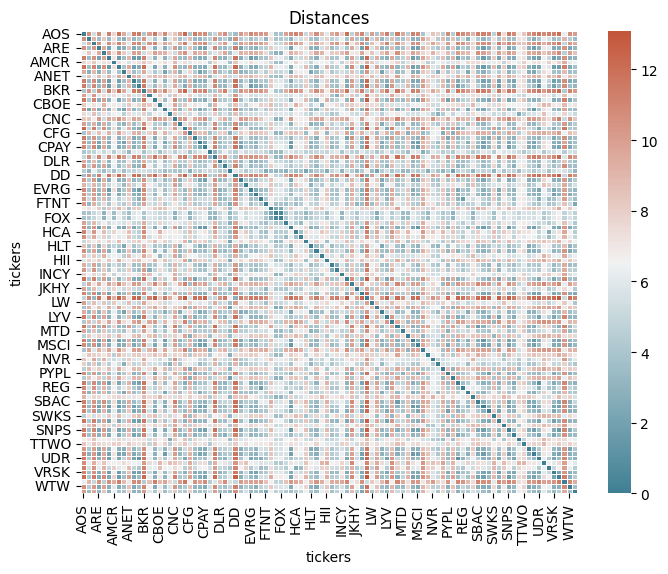

In [76]:
plots = Data_Visualization()
plots.metric(distance, "Distances","tickers","tickers")

In [77]:
plots.pair_historic(dataframes_dictionnary_norm)

# 3. Computation of spreads

In [78]:
from Spread import Spread


/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_98296/2833588483.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_98296/2833588483.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_98296/2833588483.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

{('FOX',
  'FOXA'): Ticker           FOX      FOXA  Delta_norm
 Date                                      
 2018-01-02       NaN       NaN         NaN
 2018-01-03       NaN       NaN         NaN
 2018-01-04       NaN       NaN         NaN
 2018-01-05       NaN       NaN         NaN
 2018-01-08       NaN       NaN         NaN
 ...              ...       ...         ...
 2019-12-23  0.631740  0.666870   -0.879833
 2019-12-24  0.619288  0.652902   -0.828284
 2019-12-26  0.648024  0.677234   -0.678484
 2019-12-27  0.640840  0.662815   -0.432365
 2019-12-30  0.613539  0.633076   -0.349404
 
 [502 rows x 3 columns],
 ('TMUS',
  'LYV'): Ticker          TMUS       LYV  Delta_norm
 Date                                      
 2018-01-02  0.295082  0.163553    1.706947
 2018-01-03  0.280083  0.159762    1.602151
 2018-01-04  0.258807  0.153263    1.463974
 2018-01-05  0.314614  0.181695    1.719943
 2018-01-08  0.332054  0.174384    1.951375
 ...              ...       ...         ...
 2019-12-23

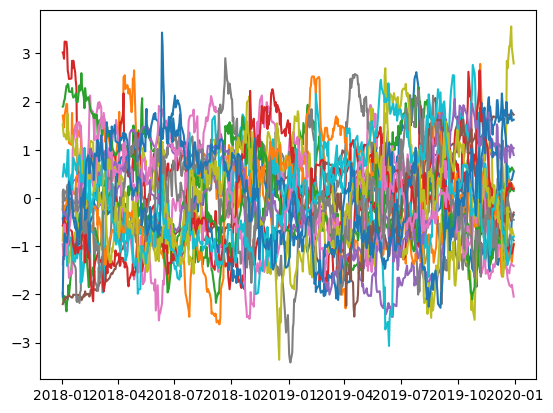

In [79]:
for key,values in dataframes_dictionnary_norm.items():

    values.loc[:,'Delta'] = values[key[0]] - values[key[1]]
    values.loc[:,'Delta_norm'] = (values['Delta'] - values['Delta'].mean()) / values['Delta'].std()
    values.drop(['Delta'], axis = 1, inplace=True )
    plt.plot(dataframes_dictionnary_norm[key]['Delta_norm'])

dataframes_dictionnary_norm




# 4. Signal creation

In [80]:
from portfolio import Signaux

In [81]:
"""data = np.array(dataframes_dictionnary_norm[('FOX','FOXA')]['Delta_norm'])
signaux = Signaux(data, 2)
signaux.entry_points_up()"""
for key,value in dataframes_dictionnary_norm.items():
    signaux = Signaux(value,2)
    value['trading_signals'] = signaux.trading_signals('Delta_norm')
    value.drop(['Trading_points'], axis = 1, inplace = True)

/Users/mcbookairdebat/Desktop/Projet/project/GitHub/Pair_trading_strategy/Pair_trading/portfolio.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/mcbookairdebat/Desktop/Projet/project/GitHub/Pair_trading_strategy/Pair_trading/portfolio.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/mcbookairdebat/Desktop/Projet/project/GitHub/Pair_trading_strategy/Pair_trading/portfolio.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [82]:
dataframes_dictionnary_norm[('NVR', 'HLT')]

Ticker,NVR,HLT,Delta_norm,trading_signals
Date,,,,
2018-01-02,0.797221,0.311141,3.016718,0
2018-01-03,0.815764,0.334626,2.977720,0
2018-01-04,0.792142,0.322582,2.886361,0
2018-01-05,0.818092,0.303312,3.243163,0
2018-01-08,0.850355,0.336433,3.236393,0
...,...,...,...,...
2019-12-23,0.940732,0.977400,-1.107881,0
2019-12-24,0.957723,0.979233,-0.988278,0
2019-12-26,0.954039,0.990838,-1.108911,0


In [83]:
data_viz = Data_Visualization()

In [84]:
data_viz.Entry_trading_points(dataframes_dictionnary_norm)